## In this Jupyter Notebook we will display the metrics calculated after training the models

##### Importing the libraries

In [11]:
from monai.utils import first
from monai.networks.nets import UNet, SegResNet, AttentionUnet, UNETR, VNet
from monai.networks.layers import Norm
from monai.metrics import HausdorffDistanceMetric
from monai.data import DataLoader, CacheDataset
from monai.losses import DiceLoss
from monai.transforms import Activations, AsDiscrete

from monai.transforms import(
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    EnsureTyped,
    ToTensord,
)

import torch
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os
from glob import glob
import numpy as np
from pathlib import Path

##### Setting the path to the directory where the model is saved and the path to the directory where the test data is stored

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = "1"

# Set the device to cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
print("Using device: ", device, "\n")

# Paths to the validation set and the model
validation_path = '../data_set_group_nif/nif_files_validation'

path_validation_volumes = glob(os.path.join(validation_path, 'images/*'))
path_validation_labels = glob(os.path.join(validation_path, 'labels/*'))

validation_files = [{'image': image_name, 'label': label_name} for image_name, label_name in zip(path_validation_volumes, path_validation_labels)]

Using device:  cuda:0 



##### Aplying the transformations to the validation data

In [3]:
# Transforms for the validation set
validation_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(0.7871384, 0.7871384, 1.2131842), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["image"], a_min=-200, a_max=250,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key='image', allow_smaller=True),
        Resized(keys=["image", "label"], spatial_size=(128, 128, 32)),
        EnsureTyped(keys=["image", "label"]),
        ToTensord(keys=["image", "label"]),
    ]
)

# Create the validation dataset
validation_ds = CacheDataset(data=validation_files, transform=validation_transforms)
validation_loader = DataLoader(validation_ds, batch_size=1)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 292/292 [03:02<00:00,  1.60it/s]


##### Loading the models

In [4]:
# Initialize the models
model1 = UNETR(
    img_size=(128, 128, 32),
    in_channels=1,
    out_channels=2,
    feature_size=32,
    hidden_size=384,
    mlp_dim=1536,
    num_heads=6,
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0
).to(device)

model2 = AttentionUnet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2)
).to(device)

model3 = UNet(
  spatial_dims=3,
  in_channels=1,
  out_channels=2,
  channels=(16, 32, 64, 128),
  strides=(2, 2, 2),
  num_res_units=2,
  norm=Norm.BATCH,
).to(device)

model4 = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    init_filters=8,
    blocks_down=(1, 2, 2, 4),
    blocks_up=(1, 1, 1),
    upsample_mode="deconv",
    dropout_prob=0.2
).to(device)

model5 = VNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    dropout_prob_down=0.5,
    dropout_prob_up=(0.5, 0.5),
    dropout_dim=3,
    bias=False
).to(device)

In [ ]:
# Current working directory
cwd = Path.cwd()

model1_path = cwd.parent / 'trained_models/post_training_UNETR_128_128_32'
model2_path = cwd.parent / 'trained_models/post_training_AttentionUNet_128_128_32'
model3_path = cwd.parent / 'trained_models/post_training_UNet_128_128_32'
model4_path = cwd.parent / 'trained_models/post_training_SegResNet_128_128_32'
model5_path = cwd.parent / 'trained_models/post_training_VNet_128_128_32'

# Load the models
model1.load_state_dict(torch.load(os.path.join(model1_path, 'best_metric_model.pth')))
model2.load_state_dict(torch.load(os.path.join(model2_path, 'best_metric_model.pth')))
model3.load_state_dict(torch.load(os.path.join(model3_path, 'best_metric_model.pth')))
model4.load_state_dict(torch.load(os.path.join(model4_path, 'best_metric_model.pth')))
model5.load_state_dict(torch.load(os.path.join(model5_path, 'best_metric_model.pth')))

# Set models to evaluation mode
model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()

##### Inferencing on the test data

In [37]:
# Initialize some variables for the metrics
true_negative_pixels = 0
true_positive_pixels = 0
false_negative_pixels = 0
false_positive_pixels = 0
total_pixels = 0
total_positive_pixels = 0
total_negative_pixels = 0
dice_coeff = 0
IoU = 0

# Prepare loss and activation outside the loop
dice_loss = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
sigmoid_func = Activations(sigmoid=True)

# For Hausdorff Distance
hausdorff_metric = HausdorffDistanceMetric(include_background=False, distance_metric='euclidean', percentile=95.0)

# For confusion matrix (flattened arrays)
all_preds = []
all_labels = []

# Infer for all the patients of the validation set
with torch.no_grad():

    for patient in validation_loader:
        volume = patient['image'].to(device)
        label = patient['label'].to(device)
        label = label != 0

        total_pixels += label.numel()

        # Apply the models
        #out1 = model1(volume)
        #out2 = model2(volume)
        out3 = model3(volume)
        out4 = model4(volume)
        out5 = model5(volume)

        out = (out3 + out4 + out5) / 3.0

        # Calculate the Dice coefficient
        dice_coeff += 1 - dice_loss(out, label).item()

        out = sigmoid_func(out)
        out = out > 0.5

        # Convert the tensor to numpy
        out = out.detach().cpu().numpy()[0, 1]
        label = label.detach().cpu().numpy()[0, 0]

        # Append predictions and labels for confusion matrix
        all_preds.extend(out.flatten())
        all_labels.extend(label.flatten())
        
        # MONAI expects [B, C, H, W, D], so reshape to that
        out_tensor = torch.tensor(out[None, None], dtype=torch.float32)
        label_tensor = torch.tensor(label[None, None], dtype=torch.float32)
        
        if np.any(out) and np.any(label):
            out_tensor = torch.tensor(out[None, None], dtype=torch.float32)
            label_tensor = torch.tensor(label[None, None], dtype=torch.float32)
            hausdorff_metric(y_pred=out_tensor, y=label_tensor)
        else:
            print("Skipping Hausdorff computation due to empty prediction or label.")

        # Calculate the IoU
        intersection = np.sum((label != 0) & (out != 0))
        union = np.sum((label != 0) | (out != 0))

        if union != 0:
            IoU += intersection / union

        false_negative_pixels += np.sum((label != 0) & (out == 0))
        false_positive_pixels += np.sum((label == 0) & (out != 0))

        true_negative_pixels += np.sum((label == 0) & (out == 0))
        true_positive_pixels += np.sum((label != 0) & (out != 0))

        total_positive_pixels += np.sum(label != 0)
        total_negative_pixels += np.sum(label == 0)

print(f'False negatives: {false_negative_pixels}/{total_pixels}')
print(f'False positives: {false_positive_pixels}/{total_pixels}')
print(f'Correct negatives: {true_negative_pixels}/{total_negative_pixels}')
print(f'Correct positives: {true_positive_pixels}/{total_positive_pixels}')

Skipping Hausdorff computation due to empty prediction or label.
Skipping Hausdorff computation due to empty prediction or label.
False negatives: 624177/153092096
False positives: 775150/153092096
Correct negatives: 138595321/139370471
Correct positives: 13097448/13721625


##### Printing the model metrics

In [38]:
num_samples = len(validation_loader)
print(f'Dice coefficient: {round(dice_coeff / num_samples, 4)}')
print(f'IoU score: {round(IoU / num_samples, 4)}')

precision = true_positive_pixels / (true_positive_pixels + false_positive_pixels + 1e-8)
recall = true_positive_pixels / (true_positive_pixels + false_negative_pixels + 1e-8)
f2_score = (5 * precision * recall) / (4 * precision + recall + 1e-8)

print(f'Recall: {round(recall, 4)}')
print(f'Precision: {round(precision, 4)}')
print(f'F2 score: {round(f2_score, 4)}')

# Compute average Hausdorff distance
hausdorff = hausdorff_metric.aggregate().item()
print(f'Hausdorff Distance (95%): {round(hausdorff, 4)}')

Dice coefficient: 0.9505
IoU score: 0.845
Recall: 0.9545
Precision: 0.9441
F2 score: 0.9524
Hausdorff Distance (95%): 6.6312


##### Ploting the confusion matrix

Confusion matrix saved as 'confusion_matrix.png'


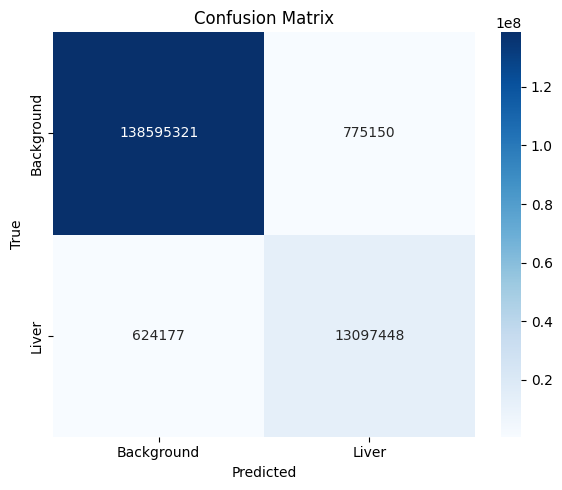

In [39]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Liver"], yticklabels=["Background", "Liver"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_ensemble.png")
print("Confusion matrix saved as 'confusion_matrix_ensemble.png'")

##### Plotting the metrics and losses after training

In [ ]:
train_loss = np.load(os.path.join(model_path, 'train_loss.npy'))
test_loss = np.load(os.path.join(model_path, 'test_loss.npy'))

train_metric = np.load(os.path.join(model_path, 'train_metric.npy'))
test_metric = np.load(os.path.join(model_path, 'test_metric.npy'))

print(len(train_metric))

# Plot the loss and metric
plt.figure(figsize=(24, 12))
plt.subplot(2, 2, 1)
plt.title('Train Loss')
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel('Epoch')
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title('Train Metric')
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel('Epoch')
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title('Test Loss')
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel('Epoch')
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title('Test Metric')
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel('Epoch')
plt.plot(x, y)

plt.savefig('trainig_evolution.png')
plt.show()